<h1 style="color: blue; text-align: center;">Unsupervised image clusterization</h1>
<hr style='border: 0; height: 2px; background: #333; background-image: linear-gradient(to right, #ccc, #333, #ccc);'>
<h2>Imports</h2>

In [1]:
from datetime import datetime
from keras.applications.resnet50 import preprocess_input, ResNet50
from keras.models import Model
from keras.preprocessing import image
from pandas import DataFrame
from random import sample
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import numpy as np
import os
import time

Using TensorFlow backend.


<hr style='border: 0; height: 1px; background: #333; background-image: linear-gradient(to right, #ccc, #333, #ccc);'>
<h2>Parameters</h2>

In [2]:
INPUT_DIRECTORY = 'UIC_dataset/'
assert os.path.exists(INPUT_DIRECTORY)

<hr style='border: 0; height: 1px; background: #333; background-image: linear-gradient(to right, #ccc, #333, #ccc);'>
<h2>Classes</h2>

<hr style='border: 0; height: 1px; background: #333; background-image: linear-gradient(to right, #ccc, #333, #ccc);'>
<h2>Functions</h2>

<hr style='border: 0; height: 1px; background: #333; background-image: linear-gradient(to right, #ccc, #333, #ccc);'>
<h2>Main program</h2>
<h3 style="margin-left: 50px;">Creating model</h3>

In [3]:
base_model = ResNet50(weights='imagenet')
model = Model(inputs=base_model.input, outputs=base_model.get_layer('avg_pool').output)
model.summary()

W0922 17:15:39.730762 14296 module_wrapper.py:139] From c:\users\jthieyre\appdata\local\programs\python\python36\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0922 17:15:39.738765 14296 module_wrapper.py:139] From c:\users\jthieyre\appdata\local\programs\python\python36\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0922 17:15:39.754765 14296 module_wrapper.py:139] From c:\users\jthieyre\appdata\local\programs\python\python36\lib\site-packages\keras\backend\tensorflow_backend.py:4185: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0922 17:15:39.805768 14296 module_wrapper.py:139] From c:\users\jthieyre\appdata\local\programs\python\python36\lib\site-packages\keras\backend\tensorflow_backend.py:174: The name tf.get_default_session is dep

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

<h3 style="margin-left: 50px;">Getting image paths</h3>

In [37]:
image_file_names = list()
image_file_paths = list()

for root_path, directory_names, file_names in os.walk(INPUT_DIRECTORY):
    for file_name in file_names:
        if file_name.lower().endswith(('.jpg', '.jpeg', '.png')):
            image_file_names.append(file_name)
            image_file_paths.append(os.path.join(root_path, file_name))
              
print('{} images found'.format(len(image_file_paths)))

27000 images found


In [6]:
image_file_names, image_file_paths = zip(*sample(list(zip(image_file_names, image_file_paths)), 1000))
image_file_names = list(image_file_names)
image_file_paths = list(image_file_paths)

<h3 style="margin-left: 50px;">Getting image features</h3>

In [7]:
image_features = list()

start_time = time.time()

for index, image_file_path in enumerate(image_file_paths.copy()):
    try:
        img = image.load_img(image_file_path, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)

        image_features.append(model.predict(x)[0])
    except OSError:
        del image_file_paths[index]
        del image_file_names[index]
        print("ERROR: Can't load image {}".format(os.path.basename(image_file_path)))

image_features = np.array(image_features)

print('Done ({:.0f} min)'.format((time.time() - start_time) / 60))

Done (8 min)


<h3 style="margin-left: 50px;">Computing t-SNE</h3>

In [27]:
start_time = time.time()

t_SNE = TSNE(n_components=2,
             perplexity=20,
             n_iter=2000,
             metric='euclidean', 
             random_state=8,
             n_jobs=-1).fit_transform(image_features)

print('Done ({:.3f} s)'.format(time.time() - start_time))

Done (24.246 s)


<h3 style="margin-left: 50px;">Ploting results</h3>

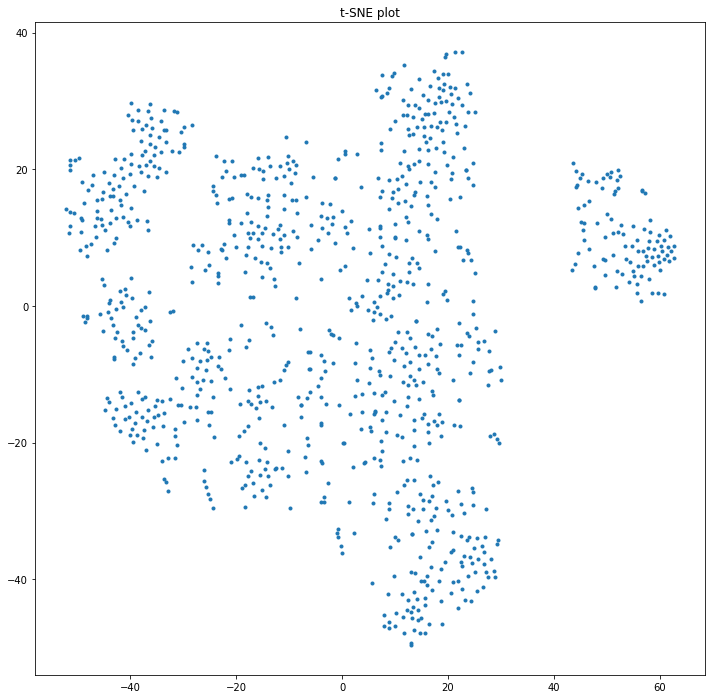

In [40]:
plt.figure(figsize=(12, 12))
plt.title('t-SNE plot')
plt.scatter(t_SNE[:, 0], t_SNE[:, 1], marker='.')
plt.show()

<h3 style="margin-left: 50px;">Saving results</h3>

In [47]:
data_frame = DataFrame(data={'Image_file_names': image_file_names,
                             'Image_file_paths': image_file_paths,
                             'Image_features': [str(vector).replace('\n', '') for vector in image_features], 
                             'Dimensionally_reduced_image_features': [str(vector).replace('\n', '') for vector in dimensionally_reduced_image_features], 
                             'X': t_SNE[:, 0], 
                             'Y': t_SNE[:, 1], 
                             'cluster': clustering})
data_frame = data_frame.set_index('Image_file_names')

data_frame.to_csv(path_or_buf='Unsupervised_image_cluterization_run_{}.csv'.format(datetime.now().strftime("%Y_%m_%d-%H_%M")),
                  sep=';',
                  encoding='utf-8')